In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy

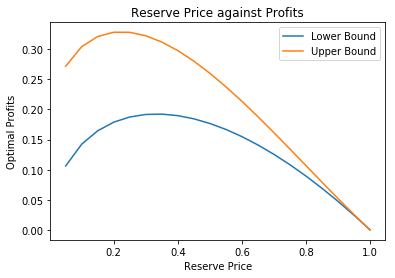

In [3]:
def pi_l(p, vmax, i, vs, dist):
    """upper bound for profits"""
    return vs*dist.cdf(p)**i + i*p*(1-dist.cdf(p))*dist.cdf(p)**(i-1)

def pi_u(p,vmax, i,vs,dist):
    """lower bound for profits"""
    integrand = lambda v:(1-dist.cdf(v))*v*dist.pdf(v)**(i-1)
    surplus = []
    for q in p:
        surplus.append( scipy.integrate.quad(integrand, q, vmax)[0] )
    return pi_l(p, vmax, i, vs, dist) + np.array(surplus)
    
support = np.arange(.05,1.05,.05)
ub = pi_u(support, 1, .5, 0, scipy.stats.uniform)
lb = pi_l(support, 1, .5, 0, scipy.stats.uniform)

plt.plot(support, lb, label='Lower Bound')
plt.plot(support, ub, label='Upper Bound')
plt.xlabel('Reserve Price')
plt.ylabel('Optimal Profits')
plt.title('Reserve Price against Profits')
plt.legend()
plt.show()

In [27]:
def pi_opt(vmax,i,vs,dist):
    """argmax of lower bound"""
    obj = lambda p: -pi_l(p,vmax,i,vs,dist)
    result = scipy.optimize.minimize(obj, vmax/2.)
    return result.x, -1*obj(result.x)

def pi_set(vmax,i,vs,dist):
    argmax, maxim = pi_opt(vmax,i,vs,dist)
    
    obj1 = lambda p: -(int(p<=argmax))*(pi_u(p,vmax,i,vs,dist)-maxim)**2
    result1 = scipy.optimize.minimize(obj1, argmax*.2 )
    
    obj2 = lambda p: -(int(p>=argmax))*(pi_u(p,vmax,i,vs,dist)-maxim)**2
    result2 = scipy.optimize.minimize(obj2, argmax*1.1)
    
    return result1.x, result2.x

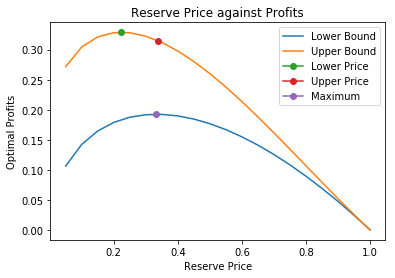

In [28]:
argmax, maxim = pi_opt(1, .5, 0, scipy.stats.uniform)
pl, pu = pi_set(1, .5, 0, scipy.stats.uniform)

gl,gu = pi_u(pl,1, .5, 0, scipy.stats.uniform), pi_u(pu,1, .5, 0, scipy.stats.uniform)

plt.plot(support, lb, label='Lower Bound')
plt.plot(support, ub, label='Upper Bound')

plt.plot(pl, gl, label='Lower Price',marker='o')
plt.plot(pu, gu, label='Upper Price',marker='o')
plt.plot(argmax, maxim, label='Maximum',marker='o')


plt.xlabel('Reserve Price')
plt.ylabel('Optimal Profits')
plt.title('Reserve Price against Profits')
plt.legend()
plt.show()

In [ ]:
def pi_est(vmax,i,vs,dist):
    """calculate the """
    argmax, maxim = pi_opt(vmax,i,vs,dist)
    #constraint to ensure we are in the ballpark
    eps=1e-4
    constr = lambda p: (pi_u(p,vmax,i,vs,dist)-maxim)**2 <= eps
    
    obj1 = lambda p: -p*(p <= argmax)*constr(p)
    result1 = scipy.optimize.minimize(obj1, argmax*.3 )
    
    obj2 = lambda p: p*(p >= argmax)*constr(p)
    result2 = scipy.optimize.minimize(obj2, argmax*1.3)
    
    return result1.x, result2.x